In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten
from PIL import Image
from utils import tile_raster_images

In [2]:
v_bias = tf.Variable(tf.zeros([7]), tf.float32)
h_bias = tf.Variable(tf.zeros([2]), tf.float32)
W = tf.constant(np.random.normal(loc=0.0, scale=1.0, size=(7, 2)).astype(np.float32))
X = tf.constant([[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]], tf.float32)
v_state = X
print ("Input: ", v_state)
h_bias = tf.constant([0.1, 0.1])
print ("hb: ", h_bias)
print ("w: ", W)
h_prob = tf.nn.sigmoid(tf.matmul(v_state, W) + h_bias)
print ("p(h|v): ", h_prob)
h_state = tf.nn.relu(tf.sign(h_prob - tf.random.uniform(tf.shape(h_prob))))
print ("h0 states:", h_state)

Input:  tf.Tensor([[1. 0. 0. 1. 0. 0. 0.]], shape=(1, 7), dtype=float32)
hb:  tf.Tensor([0.1 0.1], shape=(2,), dtype=float32)
w:  tf.Tensor(
[[ 1.4152634   1.0703057 ]
 [ 0.6324788  -1.1630542 ]
 [ 1.923204    0.9319235 ]
 [ 0.46648717  0.9940883 ]
 [ 1.7273185   0.4103853 ]
 [ 0.66253585 -0.6206821 ]
 [ 0.2647603   1.6539007 ]], shape=(7, 2), dtype=float32)
p(h|v):  tf.Tensor([[0.8788676 0.8970062]], shape=(1, 2), dtype=float32)
h0 states: tf.Tensor([[1. 1.]], shape=(1, 2), dtype=float32)


In [3]:
vb = tf.constant([0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1])
print ("b: ", vb)
v_prob = tf.nn.sigmoid(tf.matmul(h_state, tf.transpose(W)) + vb)
print ("p(vi∣h): ", v_prob)
v_state = tf.nn.relu(tf.sign(v_prob - tf.random.uniform(tf.shape(v_prob))))
print ("v probability states: ", v_state)
inp = X
print("input X:" , inp.numpy())
print("probablity vector:" , v_prob[0].numpy())
v_probability = 1
for elm, p in zip(inp[0],v_prob[0]):
    if elm ==1:
        v_probability *= p
    else:
        v_probability *= (1-p)
print("probability of generating X: " , v_probability.numpy())

b:  tf.Tensor([0.1 0.2 0.1 0.1 0.1 0.2 0.1], shape=(7,), dtype=float32)
p(vi∣h):  tf.Tensor(
[[0.92992705 0.41810063 0.95050526 0.8264359  0.9035846  0.5601705
  0.8827424 ]], shape=(1, 7), dtype=float32)
v probability states:  tf.Tensor([[0. 1. 1. 1. 1. 1. 1.]], shape=(1, 7), dtype=float32)
input X: [[1. 0. 0. 1. 0. 0. 0.]]
probablity vector: [0.92992705 0.41810063 0.95050526 0.8264359  0.9035846  0.5601705
 0.8827424 ]
probability of generating X:  0.000110061854


In [6]:
mnist = tf.keras.datasets.mnist
(trX, trY), (teX, teY) = mnist.load_data()
flatten = Flatten(dtype='float32')
trX = flatten(trX/255.0)
trY = flatten(trY/255.0)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
vb = tf.Variable(tf.zeros([784]), tf.float32)
hb = tf.Variable(tf.zeros([50]), tf.float32)
W = tf.Variable(tf.zeros([784,50]), tf.float32)
v0_state = tf.Variable(tf.zeros([784]), tf.float32)
tf.matmul( [v0_state], W)
h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)
print("h0_state shape: " , tf.shape(h0_prob))
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob))))
    return h0_state
h0_state = hidden_layer(v0_state, W, hb)
print("first 15 hidden states: ", h0_state[0][0:15])

h0_state shape:  tf.Tensor([ 1 50], shape=(2,), dtype=int32)
first 15 hidden states:  tf.Tensor([0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.], shape=(15,), dtype=float32)


In [11]:
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb)
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state[0]
v1_state = reconstructed_output(h0_state, W, vb)
print("hidden state shape: ", h0_state.shape)
print("v0 state shape:  ", v0_state.shape)
print("v1 state shape:  ", v1_state.shape)
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))
err = tf.reduce_mean(tf.square(v0_state - v1_state))
print("error" , err.numpy())
h1_prob = tf.nn.sigmoid(tf.matmul([v1_state], W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random.uniform(tf.shape(h1_prob))))
print("error: ", error(v0_state, v1_state))
alpha = 0.01
epochs = 1
batchsize = 200
weights = []
errors = []
batch_number = 0
K = 1
train_ds = tf.data.Dataset.from_tensor_slices((trX, trY)).batch(batchsize)
for epoch in range(epochs):
    for batch_x, batch_y in train_ds:
        batch_number += 1
        for i_sample in range(batchsize):
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)
                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W
                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)
                v0_state = v1_state
            if i_sample == batchsize-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % epoch,
                       "batch #: %i " % batch_number, "of %i" % int(60e3/batchsize),
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)

hidden state shape:  (1, 50)
v0 state shape:   (784,)
v1 state shape:   (784,)
error 0.47704083
error:  tf.Tensor(0.47704083, shape=(), dtype=float32)
Epoch: 0 batch #: 1  of 300 sample #: 199 reconstruction error: 0.190274
Epoch: 0 batch #: 2  of 300 sample #: 199 reconstruction error: 0.220986
Epoch: 0 batch #: 3  of 300 sample #: 199 reconstruction error: 0.106229
Epoch: 0 batch #: 4  of 300 sample #: 199 reconstruction error: 0.138406
Epoch: 0 batch #: 5  of 300 sample #: 199 reconstruction error: 0.099057
Epoch: 0 batch #: 6  of 300 sample #: 199 reconstruction error: 0.166381
Epoch: 0 batch #: 7  of 300 sample #: 199 reconstruction error: 0.078455
Epoch: 0 batch #: 8  of 300 sample #: 199 reconstruction error: 0.123435
Epoch: 0 batch #: 9  of 300 sample #: 199 reconstruction error: 0.086827
Epoch: 0 batch #: 10  of 300 sample #: 199 reconstruction error: 0.164021
Epoch: 0 batch #: 11  of 300 sample #: 199 reconstruction error: 0.085318
Epoch: 0 batch #: 12  of 300 sample #: 199 r

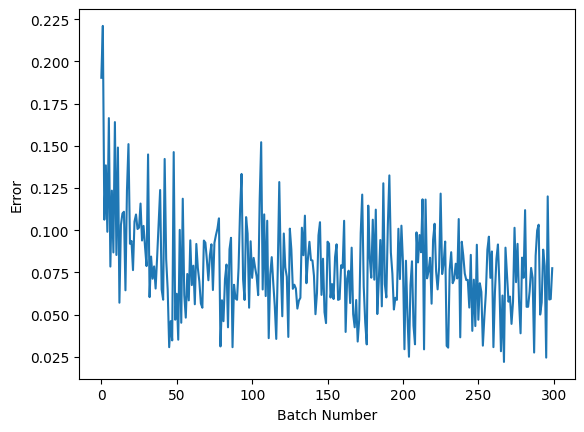

[[-0.42999986 -0.29       -0.32999995 ... -0.46999982 -0.31999996
  -0.25000003]
 [-0.3999999  -0.32999995 -0.28       ... -0.43999985 -0.32999995
  -0.26000002]
 [-0.3899999  -0.27       -0.35999992 ... -0.5399998  -0.31999996
  -0.26000002]
 ...
 [-0.44999984 -0.25000003 -0.36999992 ... -0.5399998  -0.29
  -0.29      ]
 [-0.43999985 -0.28       -0.40999988 ... -0.4799998  -0.32999995
  -0.30999997]
 [-0.42999986 -0.32999995 -0.3999999  ... -0.45999983 -0.25000003
  -0.27      ]]


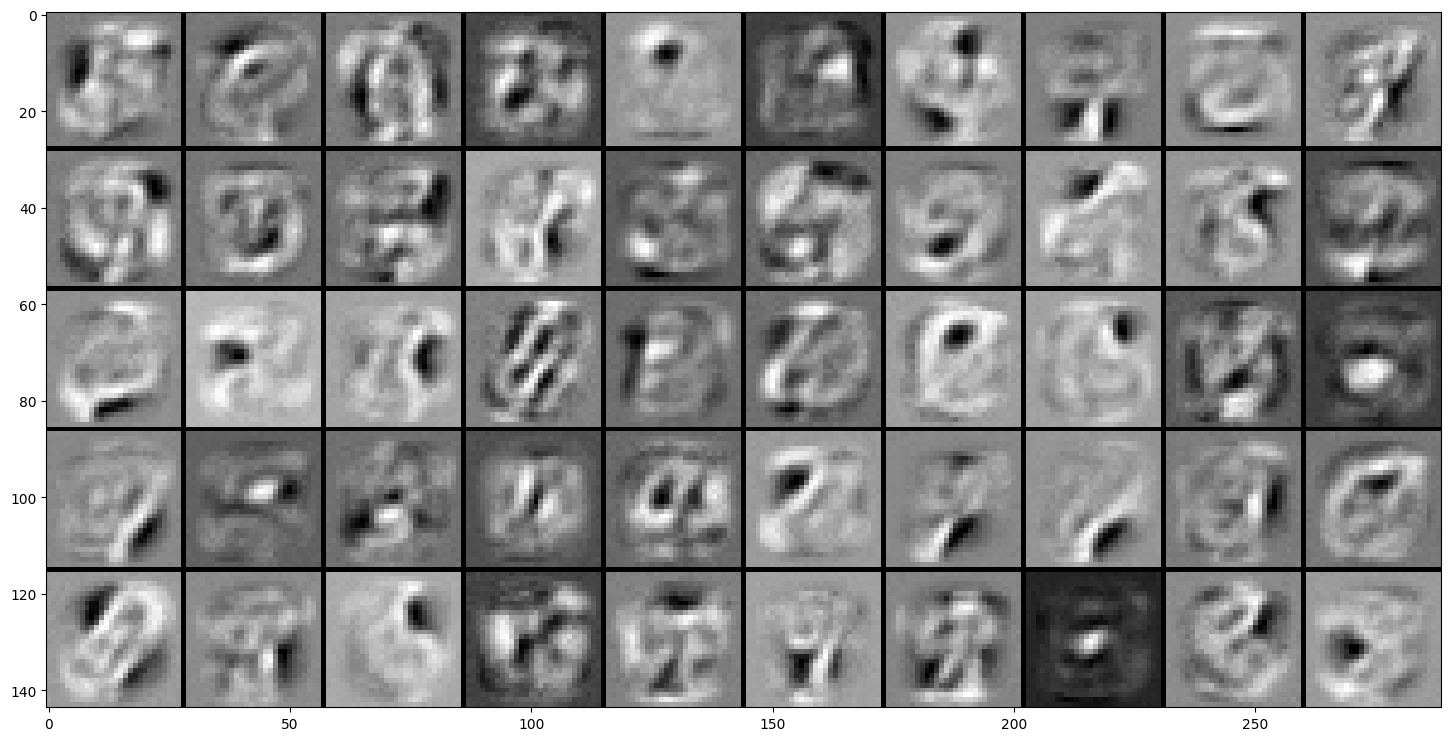

In [16]:
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()
print(W.numpy())
tile_raster_images(X=W.numpy().T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=W.numpy().T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')
tile_raster_images(X=W.numpy().T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))
image = Image.fromarray(tile_raster_images(X=W.numpy().T, img_shape=(28, 28) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')

Probability nodes in hidden layer: tf.Tensor(
[[9.9974054e-01 1.2843675e-04 2.6012787e-08 9.7848809e-01 1.6569775e-12
  1.0000000e+00 3.9632119e-17 1.1596668e-14 1.2395282e-12 6.2094387e-03
  9.2500828e-05 5.3875460e-03 2.7178432e-04 2.6483793e-11 9.9925244e-01
  1.6133603e-07 9.9999917e-01 6.5473009e-12 4.6289941e-10 1.0000000e+00
  3.6732529e-04 9.1221535e-01 1.4722595e-03 2.7826856e-04 1.2671106e-04
  3.0533862e-03 1.3211679e-06 6.1919415e-13 9.6862185e-01 9.9999326e-01
  1.1565318e-02 9.9999523e-01 8.2541280e-09 1.0000000e+00 3.6773054e-06
  1.5995800e-03 3.5840249e-13 3.3786357e-08 7.6274312e-01 9.9995375e-01
  2.4859596e-02 9.9999779e-01 8.6024294e-18 3.3918592e-08 1.3458408e-10
  3.6259403e-04 6.9155091e-01 1.0000000e+00 7.3453038e-10 9.9979460e-01]], shape=(1, 50), dtype=float32)
activated nodes in hidden layer: tf.Tensor(
[[1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1.
  0. 1.]]

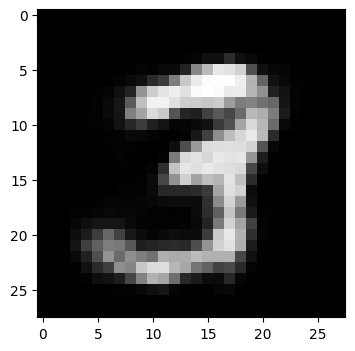

In [17]:
img = Image.open('6) destructed3.jpg')
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0
sample_case = tf.cast(sample_case, dtype=tf.float32)
hh0_p = tf.nn.sigmoid(tf.matmul(sample_case, W) + hb)
hh0_s = tf.round(hh0_p)
print("Probability nodes in hidden layer:" ,hh0_p)
print("activated nodes in hidden layer:" ,hh0_s)
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s, tf.transpose(W)) + vb)
print(vv1_p)
img = Image.fromarray(tile_raster_images(X=vv1_p.numpy(), img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')